# COVID-19 in Mexico



## Define the problem
COVID-19 is taking a big toll on the Mexican population. Currently having the 6th place worldwide. I decided to dive in and understand better the current situation in there.

The main question is: 
* Which factor has the biggest impact on predicting death once infected with COVID-19?

Other questions to tackle are:
* Is there a correlation between cases and death with days of the week?
* Does the probability of death is increased by the number of days between first symptoms and hospitalization?

* % de pruebas por entidad federativa   
* to a 100 inhabitants


* que factor tiene mayor impacto en COVID

* day of the week with more cases
* day of the week with more deaths

* Does the probability of death is increased by the number of days between first symptoms and hospitalization?

In [1]:
__author__ = "Erika Garces"
__email__ = "epgarces3@gmail.com"

In [2]:
# impory libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
import geopandas as gpd
import datetime as dt
from datetime import date

import plotly
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.tools import FigureFactory as ff
import pandas as pd

sns.set()
%matplotlib inline

## About datasets

COVID-19 data was taken from Ministry of Health MX:  https://www.gob.mx/salud/documentos/datos-abiertos-152127

Mexico's Shape File was taken from ESRI: https://www.arcgis.com/home/item.html?id=ac9041c51b5c49c683fbfec61dc03ba8

Population data was taken from INEGI: https://www.inegi.org.mx/temas/estructura/

## Load the Data 

In [3]:
# Function to print all the files in a folder 
def file_folder (path):
    filepaths = [path + f for f in listdir(path)]
    print (filepaths)

In [4]:
path = "Data/"
covid_general = file_folder(path)

['Data/.DS_Store', 'Data/mexstates.dbf', 'Data/Catalogos_0412.xlsx', 'Data/mexstates.shp', 'Data/Poblacion_01.xlsx', 'Data/mexstates.shx', 'Data/mexstates.sbx', 'Data/.keep', 'Data/Poblacion_age.xlsx', 'Data/200721COVID19MEXICO.csv', 'Data/mexstates.prj', 'Data/mexstates.sbn', 'Data/mexstates.shp.xml', 'Data/Descriptores_0419.xlsx']


In [5]:
# Loading shape file
geo_states = gpd.read_file(path + "mexstates.shp")

In [6]:
# Loading covid-19 file 
df_genera_mx = pd.read_csv(path +"200721COVID19MEXICO.csv", encoding='latin-1')
df_general = df_genera_mx

In [224]:
#Population data
df_population = pd.read_excel(open(path + 'Poblacion_01.xlsx', 'rb')) 
df_population.head()

,Num,Entidad,Total,Hombres,Mujeres
0,0,Estados Unidos Mexicanos,112336538,54855231,57481307
1,1,Aguascalientes,1184996,576638,608358
2,2,Baja California,3155070,1591610,1563460
3,3,Baja California Sur,637026,325433,311593
4,4,Campeche,822441,407721,414720


In [82]:
#COVID-19 file uses descriptors. The descriptors are analyzed below. 
df_descriptors = pd.read_excel(open(path + 'Descriptores_0419.xlsx', 'rb')) 
df_descriptors.head()

,Nº,NOMBRE DE VARIABLE,DESCRIPCIÓN DE VARIABLE,FORMATO O FUENTE
0,1,FECHA_ACTUALIZACION,"La base de datos se alimenta diariamente, esta...",AAAA-MM-DD
1,2,ID_REGISTRO,Número identificador del caso,TEXTO
2,3,ORIGEN,La vigilancia centinela se realiza a través de...,CATÁLOGO: ORIGEN ...
3,4,SECTOR,Identifica el tipo de institución del Sistema ...,CATÁLOGO: SECTOR ...
4,5,ENTIDAD_UM,Identifica la entidad donde se ubica la unidad...,CATALÓGO: ENTIDADES


In [9]:
df_states = pd.read_excel(open(path + 'Catalogos_0412.xlsx', 'rb'), sheet_name='Catálogo de ENTIDADES') 
df_states.head()

,CLAVE_ENTIDAD,ENTIDAD_FEDERATIVA,ABREVIATURA
0,1,AGUASCALIENTES,AS
1,2,BAJA CALIFORNIA,BC
2,3,BAJA CALIFORNIA SUR,BS
3,4,CAMPECHE,CC
4,5,COAHUILA DE ZARAGOZA,CL


In [10]:
df_sector = pd.read_excel(open(path + 'Catalogos_0412.xlsx', 'rb'), sheet_name='Catálogo SECTOR') 
df_sector.head()

,CLAVE,DESCRIPCIÓN
0,1,CRUZ ROJA
1,2,DIF
2,3,ESTATAL
3,4,IMSS
4,5,IMSS-BIENESTAR


In [11]:
df_paciente = pd.read_excel(open(path + 'Catalogos_0412.xlsx', 'rb'), sheet_name='Catálogo TIPO_PACIENTE') 
df_paciente

,CLAVE,DESCRIPCIÓN
0,1,AMBULATORIO
1,2,HOSPITALIZADO
2,99,NO ESPECIFICADO


In [12]:
df_gender = pd.read_excel(open(path + 'Catalogos_0412.xlsx', 'rb'), sheet_name='Catálogo SEXO') 
df_gender

,CLAVE,DESCRIPCIÓN
0,1,MUJER
1,2,HOMBRE
2,99,NO ESPECIFICADO


## Examine data

In [13]:
# checking the size of the file 
df_general.shape 

(845272, 35)

In [14]:
# checking the data type of the columns
df_general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 845272 entries, 0 to 845271
Data columns (total 35 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   FECHA_ACTUALIZACION  845272 non-null  object
 1   ID_REGISTRO          845272 non-null  object
 2   ORIGEN               845272 non-null  int64 
 3   SECTOR               845272 non-null  int64 
 4   ENTIDAD_UM           845272 non-null  int64 
 5   SEXO                 845272 non-null  int64 
 6   ENTIDAD_NAC          845272 non-null  int64 
 7   ENTIDAD_RES          845272 non-null  int64 
 8   MUNICIPIO_RES        845272 non-null  int64 
 9   TIPO_PACIENTE        845272 non-null  int64 
 10  FECHA_INGRESO        845272 non-null  object
 11  FECHA_SINTOMAS       845272 non-null  object
 12  FECHA_DEF            845272 non-null  object
 13  INTUBADO             845272 non-null  int64 
 14  NEUMONIA             845272 non-null  int64 
 15  EDAD                 845272 non-nu

In [15]:
#checking the first 5 rows.
df_general.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2020-07-21,10a31d,2,3,2,1,2,2,5,1,...,2,2,2,2,1,1,99,Mexico,99,97
1,2020-07-21,0d2fbe,2,3,25,2,25,25,6,1,...,2,2,2,1,1,1,99,Mexico,99,97
2,2020-07-21,116171,2,4,15,2,15,15,60,1,...,2,2,2,2,99,1,99,Mexico,99,97
3,2020-07-21,06d45b,2,4,15,2,15,15,121,2,...,2,1,2,2,99,1,99,Mexico,99,2
4,2020-07-21,05cbd0,2,4,31,1,30,31,101,1,...,2,2,2,2,99,1,99,Mexico,99,97


In [16]:
df_general.describe()

,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,INTUBADO,NEUMONIA,...,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,MIGRANTE,UCI
count,845272.000000,845272.000000,845272.000000,845272.000000,845272.000000,845272.000000,845272.000000,845272.000000,845272.000000,845272.000000,...,845272.000000,845272.000000,845272.000000,845272.000000,845272.000000,845272.000000,845272.000000,845272.000000,845272.000000,845272.000000
mean,1.653299,9.832802,15.676709,1.500732,16.513780,15.916306,38.610709,1.199569,78.040116,1.859036,...,2.116726,2.375248,2.254910,2.108230,2.250744,2.206887,30.714731,1.676567,98.621308,78.040967
std,0.475920,8.231811,8.117580,0.500000,9.972264,8.025663,49.513501,0.399677,37.991837,0.548663,...,5.191186,6.206989,5.142997,5.097976,5.083282,5.269297,44.718296,0.644123,6.058219,37.990272
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,4.000000,9.000000,1.000000,9.000000,9.000000,8.000000,1.000000,97.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,99.000000,97.000000
50%,2.000000,12.000000,15.000000,2.000000,15.000000,15.000000,22.000000,1.000000,97.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,99.000000,97.000000
75%,2.000000,12.000000,22.000000,2.000000,24.000000,22.000000,50.000000,1.000000,97.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,99.000000,2.000000,99.000000,97.000000
max,2.000000,99.000000,32.000000,2.000000,99.000000,32.000000,999.000000,2.000000,99.000000,99.000000,...,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,99.000000,3.000000,99.000000,99.000000


In [17]:
columns_ = df_general.columns
print(columns_)

Index(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA',
       'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'DIABETES',
       'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'RESULTADO', 'MIGRANTE', 'PAIS_NACIONALIDAD',
       'PAIS_ORIGEN', 'UCI'],
      dtype='object')


In [18]:
def value_counter(df, columns):
    for col in columns:
        result = df[col].value_counts()
        print (result) 

In [19]:

columns_remove = ('SECTOR','ORIGEN','FECHA_ACTUALIZACION', 'ID_REGISTRO','ENTIDAD_UM', 'EDAD',
                  'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES','FECHA_INGRESO', 
                  'FECHA_SINTOMAS', 'FECHA_DEF','PAIS_NACIONALIDAD', 'MIGRANTE', 'PAIS_ORIGEN')
item_list = ['item', 5, 'foo', 3.14, True]
columns_review = [col for col in columns_ if col not in columns_remove]

In [20]:
value_counter(df_general, columns_review)

2    423255
1    422017
Name: SEXO, dtype: int64
1    676582
2    168690
Name: TIPO_PACIENTE, dtype: int64
97    676582
2     154163
1      14386
99       141
Name: INTUBADO, dtype: int64
2     724551
1     120705
99        16
Name: NEUMONIA, dtype: int64
1    840962
2      4310
Name: NACIONALIDAD, dtype: int64
97    423255
2     413146
1       6236
98      2635
Name: EMBARAZO, dtype: int64
2     809626
99     27995
1       7651
Name: HABLA_LENGUA_INDIG, dtype: int64
2     737374
1     105249
98      2649
Name: DIABETES, dtype: int64
2     830447
1      12487
98      2338
Name: EPOC, dtype: int64
2     817342
1      25596
98      2334
Name: ASMA, dtype: int64
2     830614
1      12037
98      2621
Name: INMUSUPR, dtype: int64
2     705511
1     137303
98      2458
Name: HIPERTENSION, dtype: int64
2     818691
1      23037
98      3544
Name: OTRA_COM, dtype: int64
2     825030
1      17812
98      2430
Name: CARDIOVASCULAR, dtype: int64
2     706866
1     136036
98      2370
Name: OBESI

## Data Cleaning

In [21]:
df_general['ENTIDAD'] = df_general['ENTIDAD_UM'].map(df_states.set_index('CLAVE_ENTIDAD')['ENTIDAD_FEDERATIVA'])
df_general['SECTOR'] = df_general['SECTOR'].map(df_sector.set_index('CLAVE')['DESCRIPCIÓN'])

In [22]:
df_general['TIPO_PACIENTE'] = df_general['TIPO_PACIENTE'].map(df_paciente.set_index('CLAVE')['DESCRIPCIÓN'])
df_general['SEXO']= df_general['SEXO'].replace([1, 2], ['Women', 'Men'])


In [23]:
# It replace values for several columns in a dataframe.
def replace_values(df, columns, 
                   old_values, new_values):
    for col in columns:
        try:
            df[col]= df[col].replace(to_replace=old_values, value=new_values)
        except:
            print(col)
    return df 

In [24]:
# It cast values for several columns in a dataframe.
def cast_values(df, columns, cast_value):
    for col in columns:
        try:
            df[col]= df[col].astype(cast_value)
        except:
            print(col)
    return df 

The columns below are dropped. 

In [25]:
df_general = df_general.drop(['ENTIDAD_NAC', 'ENTIDAD_RES', 'NACIONALIDAD', 
                              'PAIS_NACIONALIDAD', 'HABLA_LENGUA_INDIG', 'MIGRANTE'], axis=1)

The column ['FECHA_DEF'] uses '9999-99-99', so I imputed this value to zero. This helps further calculations. 

In [26]:
df_general['FECHA_DEF'] = df_general['FECHA_DEF'].replace('9999-99-99', 0)

In [27]:
df_general['DEF'] = df_general.FECHA_DEF.apply(lambda x: 1 if x!=0 else 0)

In [28]:
#the columns were formatted to datetime.
df_general['FECHA_INGRESO'] = pd.to_datetime(df_general['FECHA_INGRESO'].str.strip(), format='%Y/%m/%d')
df_general['FECHA_SINTOMAS'] = pd.to_datetime(df_general['FECHA_SINTOMAS'].str.strip(), format='%Y/%m/%d')
df_general['FECHA_DEF'] = pd.to_datetime(df_general['FECHA_DEF'].str.strip(), format='%Y/%m/%d', errors='ignore')

In [29]:
def cal_time_days(df, column_a, column_b, new_name):
    df[new_name] = df[column_a] -  df[column_b]
    df[new_name] = df[new_name].dt.days.astype("Int32")
    df[new_name] = df[new_name].fillna(0)
    return df

In [30]:
df_general.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,...,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,PAIS_ORIGEN,UCI,ENTIDAD,DEF
0,2020-07-21,10a31d,2,ESTATAL,2,Women,5,AMBULATORIO,2020-04-28,2020-04-24,...,2,2,2,2,1,1,99,97,BAJA CALIFORNIA,0
1,2020-07-21,0d2fbe,2,ESTATAL,25,Men,6,AMBULATORIO,2020-05-25,2020-05-18,...,2,2,2,1,1,1,99,97,SINALOA,0
2,2020-07-21,116171,2,IMSS,15,Men,60,AMBULATORIO,2020-04-15,2020-04-05,...,2,2,2,2,99,1,99,97,MÉXICO,0
3,2020-07-21,06d45b,2,IMSS,15,Men,121,HOSPITALIZADO,2020-04-23,2020-04-22,...,2,1,2,2,99,1,99,2,MÉXICO,1
4,2020-07-21,05cbd0,2,IMSS,31,Women,101,AMBULATORIO,2020-05-04,2020-04-30,...,2,2,2,2,99,1,99,97,YUCATÁN,0


Added columns to know number of days between:
* a patient had symptoms to his/her death.
* a patient has symptoms to be hospitalized.
* a patient was hospitalized symptoms to his/her death.
    


In [31]:
cal_time_days(df_general,'FECHA_DEF', 'FECHA_SINTOMAS', 'DIAS_SINT_DEF')
cal_time_days(df_general,'FECHA_DEF', 'FECHA_INGRESO', 'DIAS_ING_DEF')
cal_time_days(df_general,'FECHA_INGRESO', 'FECHA_SINTOMAS', 'DIAS_SINT_ING')

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,...,TABAQUISMO,OTRO_CASO,RESULTADO,PAIS_ORIGEN,UCI,ENTIDAD,DEF,DIAS_SINT_DEF,DIAS_ING_DEF,DIAS_SINT_ING
0,2020-07-21,10a31d,2,ESTATAL,2,Women,5,AMBULATORIO,2020-04-28,2020-04-24,...,2,1,1,99,97,BAJA CALIFORNIA,0,0,0,4
1,2020-07-21,0d2fbe,2,ESTATAL,25,Men,6,AMBULATORIO,2020-05-25,2020-05-18,...,1,1,1,99,97,SINALOA,0,0,0,7
2,2020-07-21,116171,2,IMSS,15,Men,60,AMBULATORIO,2020-04-15,2020-04-05,...,2,99,1,99,97,MÉXICO,0,0,0,10
3,2020-07-21,06d45b,2,IMSS,15,Men,121,HOSPITALIZADO,2020-04-23,2020-04-22,...,2,99,1,99,2,MÉXICO,1,7,6,1
4,2020-07-21,05cbd0,2,IMSS,31,Women,101,AMBULATORIO,2020-05-04,2020-04-30,...,2,99,1,99,97,YUCATÁN,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845267,2020-07-21,09d62a,2,SSA,9,Women,9,AMBULATORIO,2020-07-20,2020-07-17,...,2,1,3,99,97,CIUDAD DE MÉXICO,0,0,0,3
845268,2020-07-21,15da6e,2,SSA,11,Men,20,AMBULATORIO,2020-07-20,2020-07-20,...,2,1,3,99,97,GUANAJUATO,0,0,0,0
845269,2020-07-21,1a8200,2,SSA,8,Women,19,AMBULATORIO,2020-07-19,2020-07-11,...,2,2,3,99,97,CHIHUAHUA,0,0,0,8
845270,2020-07-21,052e2b,1,SSA,21,Women,53,AMBULATORIO,2020-07-20,2020-07-12,...,2,2,3,99,97,PUEBLA,0,0,0,8


The column specifies whether the patient is alive or dead.

In [32]:
df_general['FECHA_INGRESO_SEMANAL'] = df_general['FECHA_INGRESO'].dt.dayofweek
df_general['WEEKEND'] = df_general['FECHA_INGRESO_SEMANAL'].apply(lambda x: 1 if (x>4) else 0)

In [33]:
df_general.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,...,RESULTADO,PAIS_ORIGEN,UCI,ENTIDAD,DEF,DIAS_SINT_DEF,DIAS_ING_DEF,DIAS_SINT_ING,FECHA_INGRESO_SEMANAL,WEEKEND
0,2020-07-21,10a31d,2,ESTATAL,2,Women,5,AMBULATORIO,2020-04-28,2020-04-24,...,1,99,97,BAJA CALIFORNIA,0,0,0,4,1,0
1,2020-07-21,0d2fbe,2,ESTATAL,25,Men,6,AMBULATORIO,2020-05-25,2020-05-18,...,1,99,97,SINALOA,0,0,0,7,0,0
2,2020-07-21,116171,2,IMSS,15,Men,60,AMBULATORIO,2020-04-15,2020-04-05,...,1,99,97,MÉXICO,0,0,0,10,2,0
3,2020-07-21,06d45b,2,IMSS,15,Men,121,HOSPITALIZADO,2020-04-23,2020-04-22,...,1,99,2,MÉXICO,1,7,6,1,3,0
4,2020-07-21,05cbd0,2,IMSS,31,Women,101,AMBULATORIO,2020-05-04,2020-04-30,...,1,99,97,YUCATÁN,0,0,0,4,0,0


I decided to impute the data from values [97,98 and 99] to be 'no'. The values are used in the columns of preconditions of patients. Many times care providers mark as not applicable when a patient doesn't present the condition. 

In [34]:
#Selecting the columns that have a format of SI and NO.
df_descriptors['FORMATO O FUENTE'] = df_descriptors['FORMATO O FUENTE'].str.strip()
df_si_no_answer = df_descriptors[df_descriptors['FORMATO O FUENTE']== 'CATÁLOGO: SI_ NO']
column_list_binary = list(df_si_no_answer['NOMBRE DE VARIABLE'].values)
column_list_binary.append('RESULTADO')
column_list_binary.append('OTRO_CASO')
column_list_binary

['INTUBADO',
 'NEUMONIA',
 'EMBARAZO',
 'HABLA_LENGUA_INDIG',
 'DIABETES',
 'EPOC',
 'ASMA',
 'INMUSUPR',
 'HIPERTENSION',
 'OTRAS_COM',
 'CARDIOVASCULAR',
 'OBESIDAD',
 'RENAL_CRONICA',
 'TABAQUISMO',
 'OTRO_CASO',
 'MIGRANTE',
 'UCI',
 'RESULTADO',
 'OTRO_CASO']

In [35]:
#The values for the columns with SI NO format are replace with 1 and 0.
df_general =replace_values(df_general, column_list_binary, [97, 98, 99], [2,2,2])
df_general =replace_values(df_general, column_list_binary, [1,2], [1,0])


HABLA_LENGUA_INDIG
OTRAS_COM
MIGRANTE
HABLA_LENGUA_INDIG
OTRAS_COM
MIGRANTE


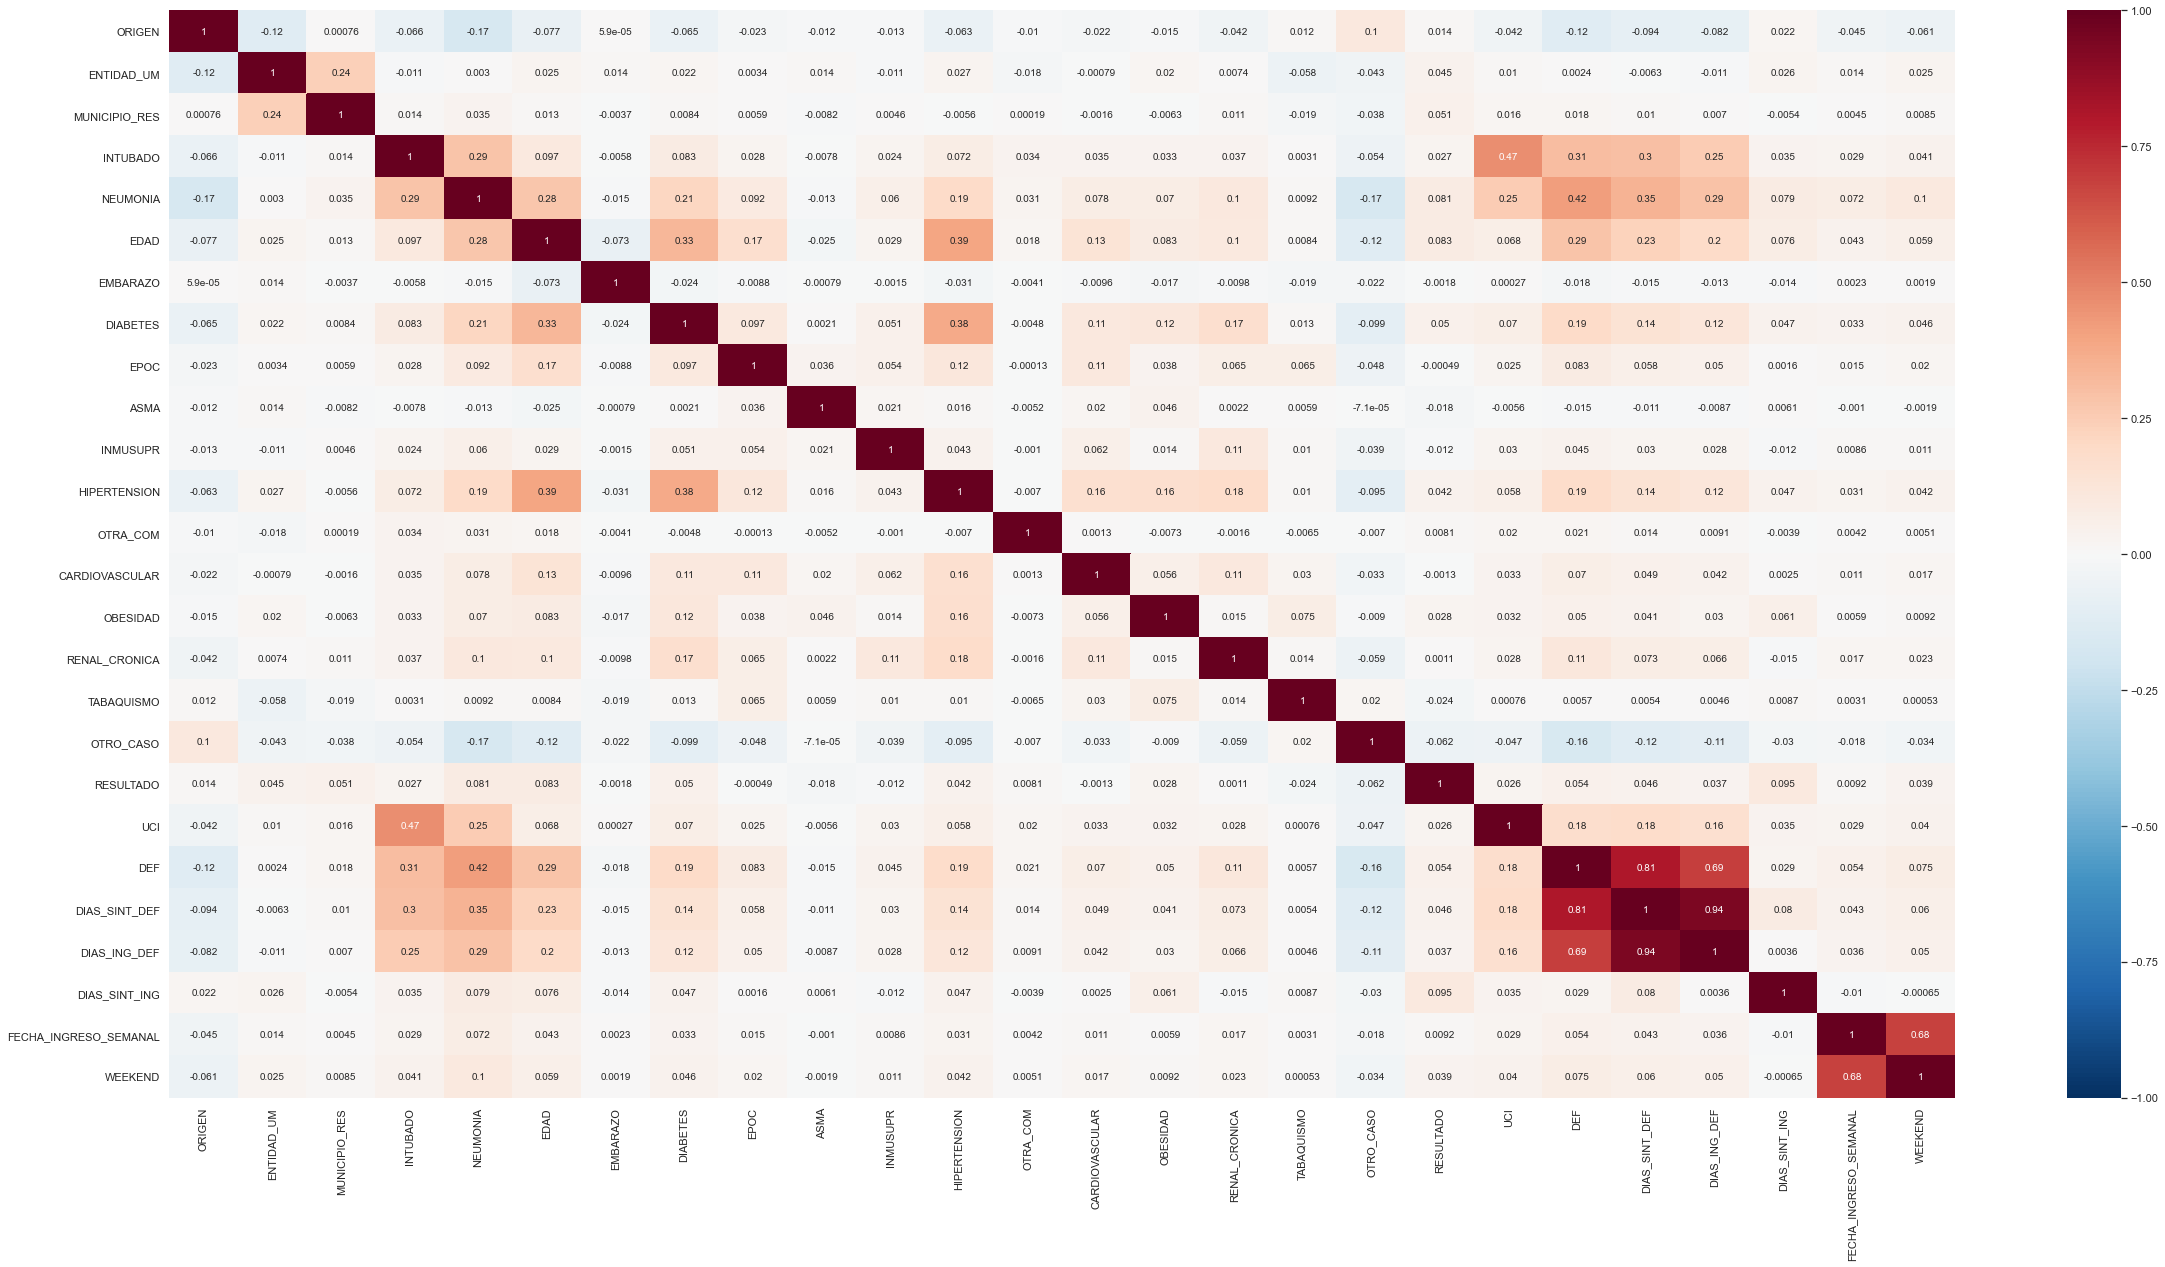

In [36]:
correlation = df_general.corr()
plt.figure(figsize=(40, 20))
sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

### Geo data
The column for federal entities' abbreviation is transformed to match the column "ENTIDAD_UM" in the COVID-19 data frame .  

In [37]:
geo_states['FIPS_ADMIN'] = geo_states['FIPS_ADMIN'].str.replace("MX0","")
geo_states['FIPS_ADMIN'] = geo_states['FIPS_ADMIN'].str.replace("MX","")

## Exploratory Data Analysis 

### States with more COVID-19 tests



The figure below shows percentage of COVID-19 tests done in Mexico broken by state. Mexico city is the federal entity with the most number of tests. In second place is Mexico (the state). 

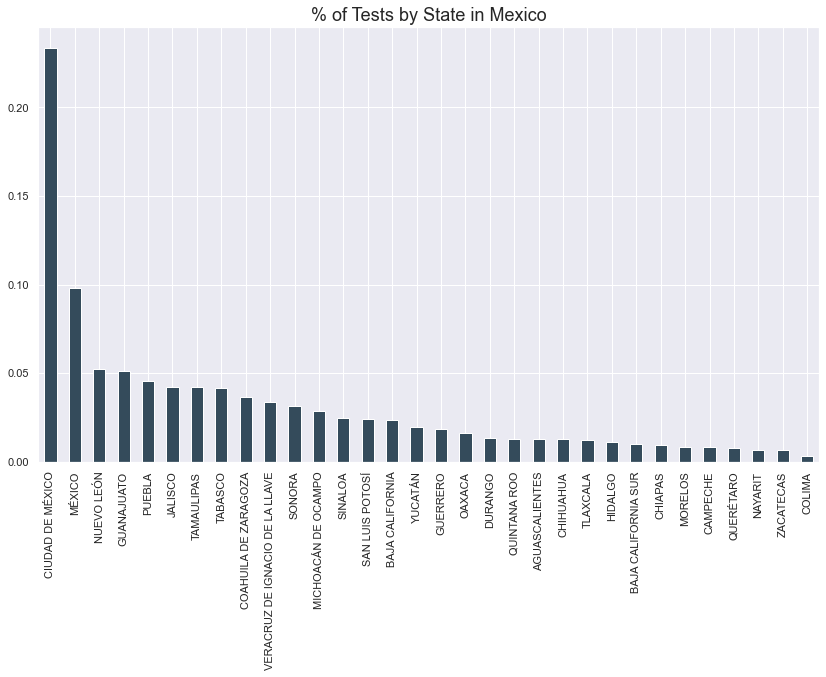

In [38]:
states_vals = df_general.ENTIDAD.value_counts()
sns.set(palette="Blues_d")
fig = plt.figure(figsize=(14,8))
(states_vals/df_general.shape[0]).plot(kind="bar");
plt.title("% of Tests by State in Mexico", fontsize = 18);
plt.show()

The data frame is filtered, to focus on only on patient with COVID-19.

In [190]:
df_states_by_result = df_general.copy()
indexPendintResult = df_states_by_result[ df_states_by_result['RESULTADO'] == 3 ].index
df_states_by_result.drop(indexPendintResult , inplace=True)
df_states_by_result['RESULTADO'].replace(to_replace=[1,0], value=['POSITIVO','NO POSITIVO'],inplace=True)

In [191]:
pd.crosstab(df_states_by_result.FECHA_ACTUALIZACION, df_states_by_result.RESULTADO)

RESULTADO,NO POSITIVO,POSITIVO
FECHA_ACTUALIZACION,,
2020-07-21,406151,356255


In [192]:
df_state_results = pd.crosstab(df_states_by_result.ENTIDAD, df_states_by_result.RESULTADO, normalize=True)

In [193]:
df_state_results = df_state_results.reset_index()

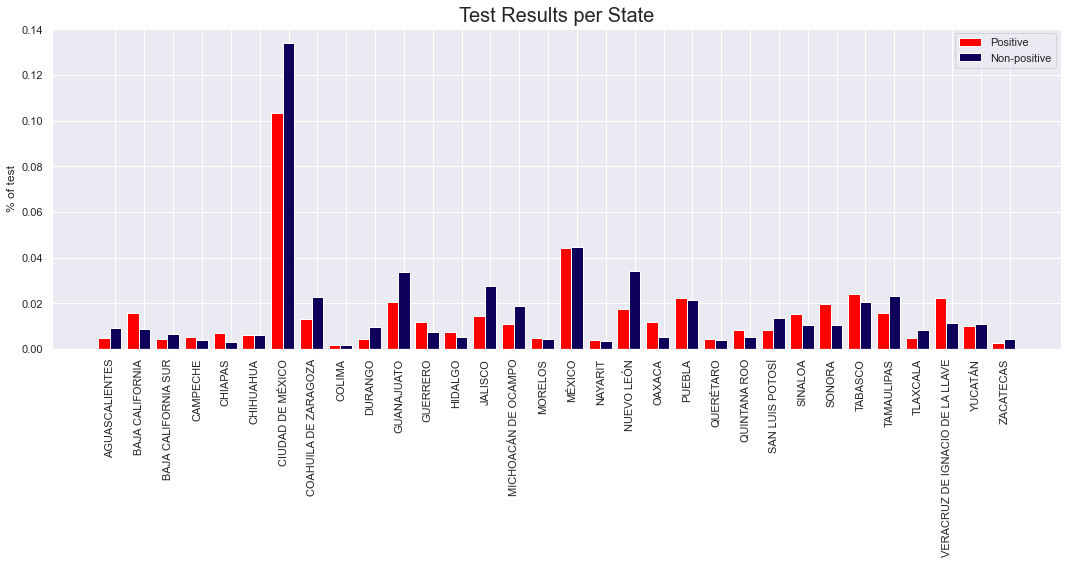

In [194]:
width = 0.40
x = np.arange(len(df_state_results.ENTIDAD))
fig, ax = plt.subplots(figsize=(15, 8))

rects1 = ax.bar(x - width/2, df_state_results.POSITIVO, width, label='Positive', color = '#ff0000')
rects2 = ax.bar(x + width/2, df_state_results['NO POSITIVO'], width, label='Non-positive', color = '#0c005a')

ax.set_ylabel('% of test')
ax.set_title('Test Results per State', fontsize = 20)
ax.set_xticks(x + width/2 )
ax.set_xticklabels(df_state_results.ENTIDAD, rotation=90, ha='right')
ax.legend()
fig.tight_layout()

plt.show()


The graph shows the results of the tests done by federal entity. The results in the graphs have been normalized.

## Values  per Capita

In [195]:
df_states_key_vals = df_general.ENTIDAD_UM.value_counts().to_frame()
df_states_key_vals = df_states_key_vals.reset_index()
df_states_key_vals.rename(columns={df_states_key_vals.columns[0]: 'ENTIDAD' ,
                                   'ENTIDAD_UM':  'VALUES'}, inplace = True)

In [196]:
df_population = pd.merge(df_population, df_states_key_vals, left_on='Num', right_on='ENTIDAD')

In [197]:
df_population['PER_CAPITA'] = df_population['VALUES'] / df_population['Total'] * 100000

In [198]:
df_population['VALUES'].sum() / df_population['Total'].sum() * 100000

752.4461898585481

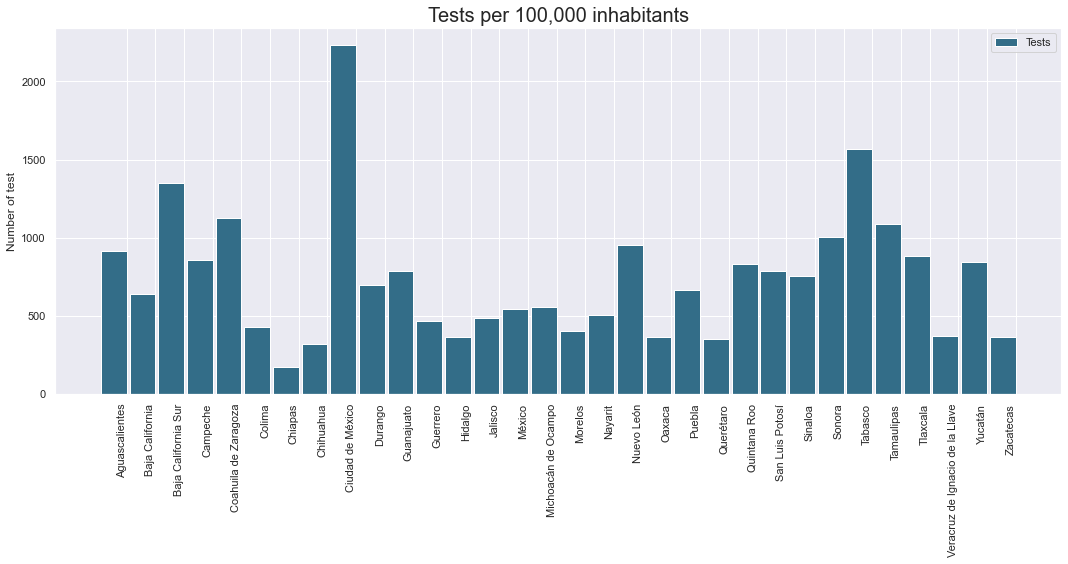

In [200]:
width = 0.9 
x = np.arange(len(df_population.Entidad))
fig, ax = plt.subplots(figsize=(15, 8))

ax.bar(x, df_population['PER_CAPITA'], width, label='Tests', color = '#336d88')
ax.set_ylabel('Number of test')
ax.set_title('Tests per 100,000 inhabitants', fontsize = 20)
ax.set_xticks(x + width/2 )
ax.set_xticklabels(df_population.Entidad, rotation=90, ha='right')
ax.legend()
fig.tight_layout()

plt.show()

### Positive cases per 100,000 inhabitants

In [225]:
df_result_tests = df_states_by_result.groupby(['ENTIDAD_UM', 'RESULTADO']).size().unstack()

In [226]:
df_result_tests = df_result_tests.reset_index()

In [229]:
df_population = pd.merge(df_population, df_result_tests, left_on='Num', right_on='ENTIDAD_UM')

In [231]:
df_population['POS_PER_CAPITA'] = df_population['POSITIVO'] / df_population['Total'] * 100000

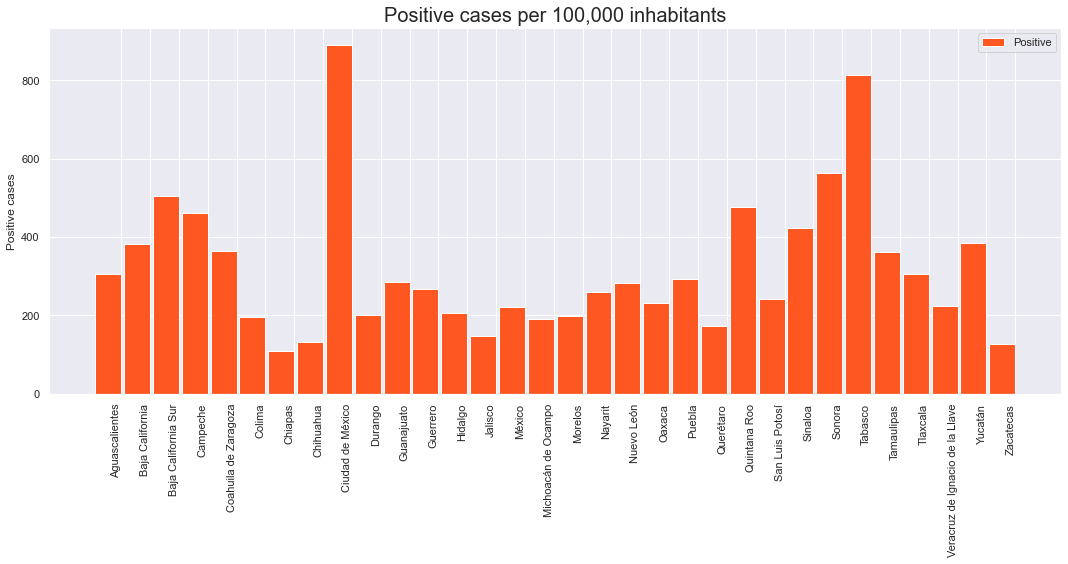

In [235]:
width = 0.9 
x = np.arange(len(df_population.Entidad))
fig, ax = plt.subplots(figsize=(15, 8))

ax.bar(x, df_population['POS_PER_CAPITA'], width, label='Positive', color = '#ff5722')
ax.set_ylabel('Positive cases')
ax.set_title('Positive cases per 100,000 inhabitants', fontsize = 20)
ax.set_xticks(x + width/2 )
ax.set_xticklabels(df_population.Entidad, rotation=90, ha='right')
ax.legend()
fig.tight_layout()

plt.show()

###  Summary of Confimed/Deaths

In [45]:
df_positive = df_general[ df_general['RESULTADO'] == 1]
df_positive = df_positive[['FECHA_ACTUALIZACION','FECHA_INGRESO', 'FECHA_DEF',
                           'RESULTADO', 'DEF', 'DIAS_SINT_ING', 'SEXO', 'EDAD']]

In [46]:
df_positive.rename({'EDAD': "Age"}, axis=1, inplace=True)

In [47]:
df_positive.DEF.sum()

40400

In [48]:
def bar_char (x_val, y_val, color_num, title_chart, y_axis_name, x_axis_name, figsize=(18,8)):
    fig, ax = plt.subplots(figsize= figsize)
    x_pos = np.arange(len(x_val))

    plt.bar(x_pos, y_val, color=color_num)
    plt.ylabel(y_axis_name)
    plt.xlabel(x_axis_name)
    plt.title(title_chart, fontsize = 20)

    plt.show()
    

In [49]:
df_death = pd.crosstab(df_positive['FECHA_DEF'], df_positive.DEF)
df_death = df_death.reset_index()
df_death.rename({1: 'DEF'}, axis=1, inplace=True)

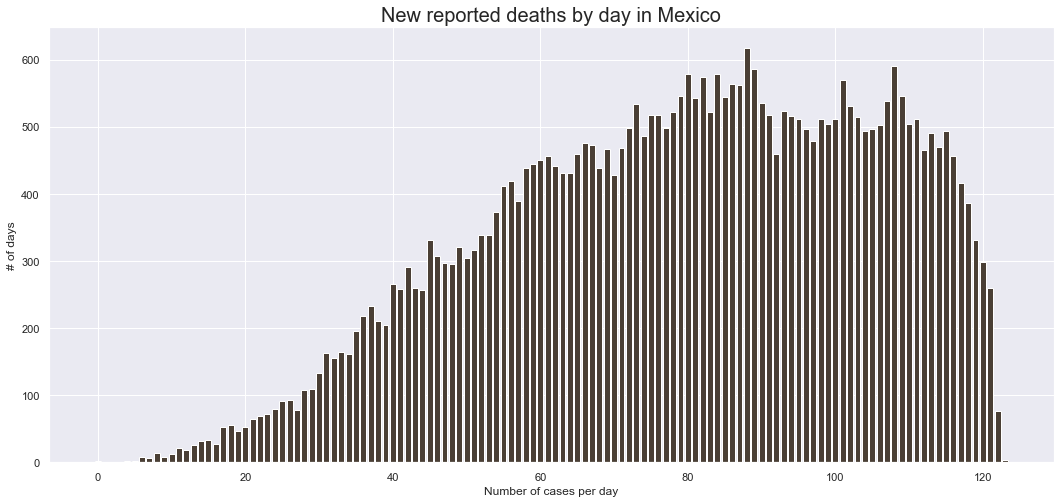

In [50]:
bar_char(df_death.FECHA_DEF, 
         df_death.DEF, 
         '#4a3f35', 
         'New reported deaths by day in Mexico', 
         '# of days',
         'Number of cases per day')

Average number of days between first symptoms to death

In [51]:
df_dying  = df_general[(df_general['RESULTADO'] == 1 ) & (df_general['DEF'] == 1 )]
df_dying = df_dying[['FECHA_DEF','DIAS_SINT_DEF', 'FECHA_INGRESO_SEMANAL', 'SEXO']]
df_dying.set_index('FECHA_DEF', inplace=True)
df_dying.index = pd.to_datetime(df_dying.index)

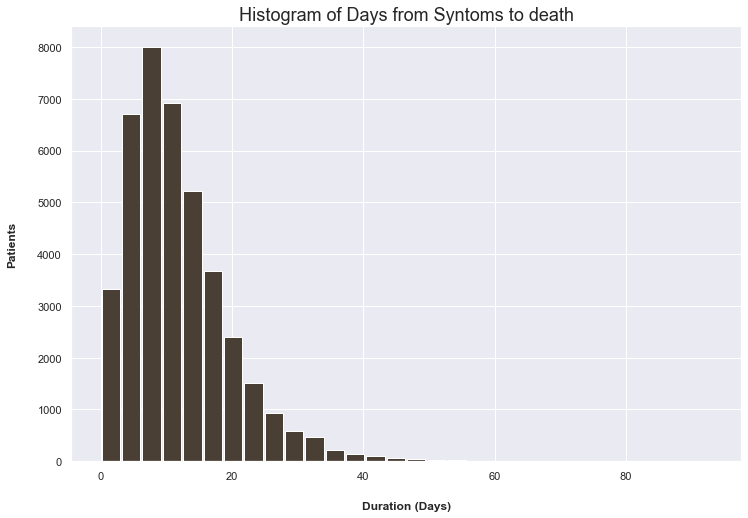

In [52]:
ax = df_dying.hist(column='DIAS_SINT_DEF', bins=30, grid=True, figsize=(12,8), color='#4a3f35',  rwidth=0.9)

for x in ax[0]:
    x.set_title("Histogram of Days from Syntoms to death", fontsize = 18)
    x.set_xlabel("Duration (Days)", labelpad=20, weight='bold', size=12)
    x.set_ylabel("Patients", labelpad=20, weight='bold', size=12)



In [53]:
outlier = df_dying[df_dying['DIAS_SINT_DEF']>30].count()
outlier

DIAS_SINT_DEF            1122
FECHA_INGRESO_SEMANAL    1122
SEXO                     1122
dtype: int64

The avergare number of days for a patient with COVID19 to dies is almost 12. There are cases that takes up to more than 3 months.


In [54]:
df_dying.describe()

,DIAS_SINT_DEF,FECHA_INGRESO_SEMANAL
count,40400.000000,40400.00000
mean,11.923738,2.86453
std,7.791492,1.99078
min,0.000000,0.00000
25%,7.000000,1.00000
50%,10.000000,3.00000
75%,16.000000,5.00000
max,93.000000,6.00000


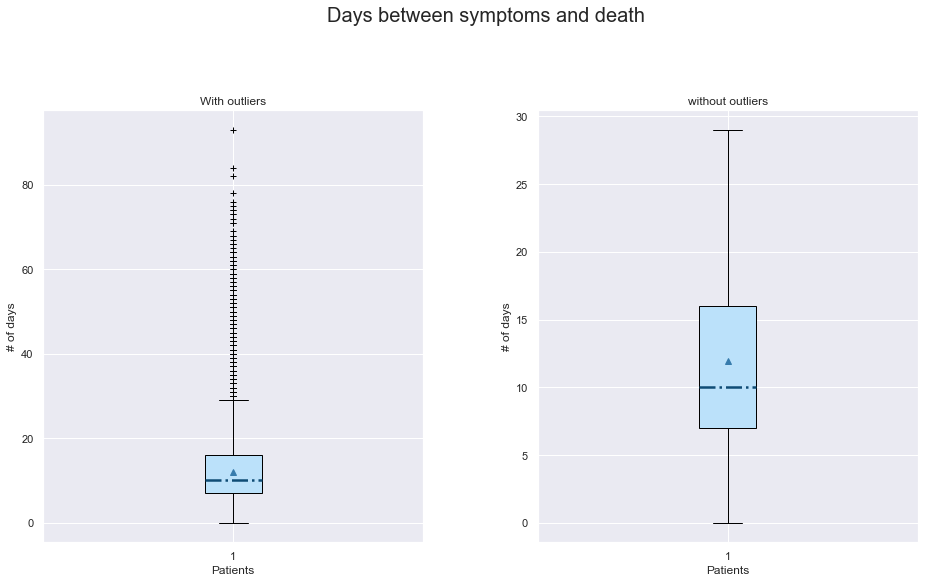

In [55]:
fig, axs =plt.subplots(1,2, figsize=(15, 8))
meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
medianprops = dict(linestyle='-.', linewidth=2.5, color='#0f4c75')

axs[0].boxplot(df_dying['DIAS_SINT_DEF'],notch=0, sym='+', vert=1, whis=1.5,  patch_artist=True, 
               medianprops=medianprops, boxprops=dict(facecolor='#bbe1fa'),showmeans=True )
axs[0].set_title('With outliers')
axs[0].set_ylabel('# of days')
axs[0].set_xlabel('Patients')

axs[1].boxplot(df_dying['DIAS_SINT_DEF'], 0, '', patch_artist=True, 
               boxprops=dict(facecolor='#bbe1fa'), showmeans=True, medianprops=medianprops)
axs[1].set_title("without outliers")
axs[1].set_ylabel('# of days')
axs[1].set_xlabel('Patients')

fig.suptitle('Days between symptoms and death', fontsize=20)
fig.subplots_adjust(left=0.09, right=0.9, bottom=0.05, top=0.8,
                    hspace=0.4, wspace=0.3)

The boxplots show the distribution between number of days from first symptoms to death. The first boxplot includes outlier. In the second boxplot the outliers are removed.

### Confirmed Positive COVID-19 cases

In [56]:
gender_vals = list(df_positive.SEXO.value_counts(normalize=True))

In [57]:
gender_vals

[0.535821251631556, 0.46417874836844397]

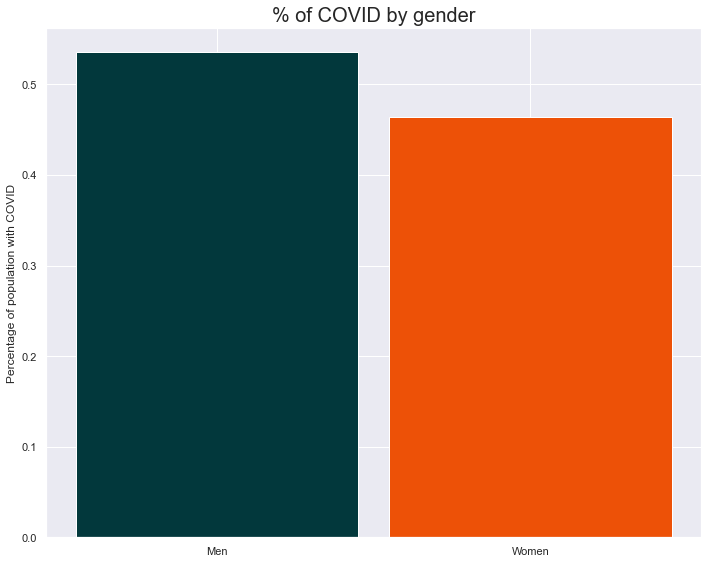

In [58]:
gender = ['Men', 'Women']
colors = ['#02383c', '#ed5107']

x = np.arange(len(gender))
fig, ax = plt.subplots(figsize=(10, 8))
width = 0.9

rects1 = ax.bar(x, gender_vals, width, color = colors)

ax.set_ylabel('Percentage of population with COVID')
ax.set_title('% of COVID by gender', fontsize = 20)
ax.set_xticks(x)
ax.set_xticklabels(gender)
fig.tight_layout()

plt.show()

The graphs show the percentage of the population that has been infected with COVID-19. 

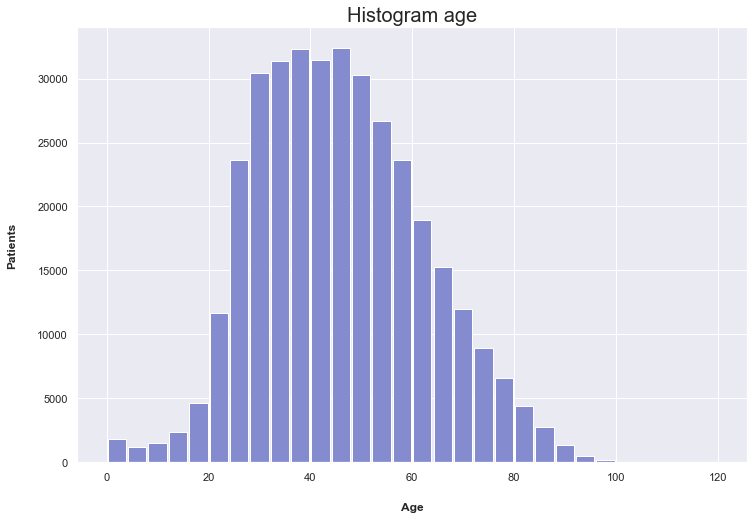

In [59]:
ax = df_positive.hist(column='Age', bins=30, grid=True, figsize=(12,8), color='#848ccf',  rwidth=0.9)

for x in ax[0]:
    x.set_title("Histogram age", fontsize = 20)
    x.set_xlabel("Age", labelpad=20, weight='bold', size=12)
    x.set_ylabel("Patients", labelpad=20, weight='bold', size=12)

In [60]:
df_age_women = df_positive[df_positive.SEXO == 'Women']
df_age_men = df_positive[df_positive.SEXO == 'Men']
age_women = list(df_age_women['Age'])
age_men = list(df_age_men['Age'])

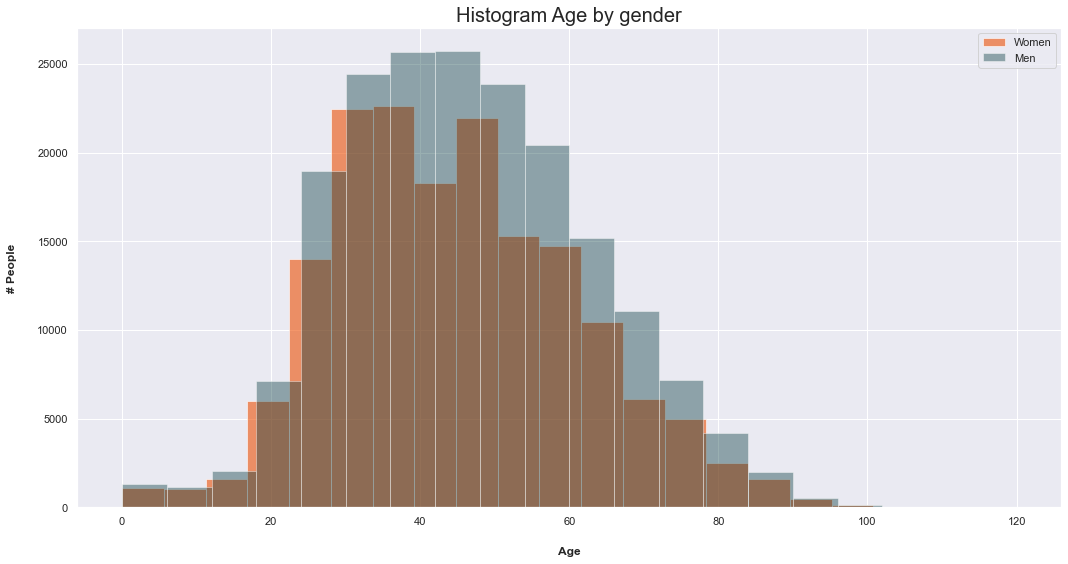

In [61]:
fig, ax =plt.subplots(figsize=(15, 8))

bins = 20 
ax.hist(age_women, bins, alpha=0.6, label='Women', color='#ed5107' )
ax.hist(age_men, bins, alpha=0.4, label='Men', color='#02383c')
ax.legend()
ax.set_title('Histogram Age by gender', fontsize = 20)
ax.set_xlabel("Age", labelpad=20, weight='bold', size=12)
ax.set_ylabel("# People", labelpad=20, weight='bold', size=12)
fig.tight_layout()

plt.show()

Histogram of age broken by gender. 

In [62]:
df_hosp = df_positive[['FECHA_INGRESO', 'DIAS_SINT_ING']]
print ('Average number of days between first symptoms to hospitalization : ' + str(df_hosp.DIAS_SINT_ING.mean()))

Average number of days between first symptoms to hospitalization : 4.240041543276585


In [63]:
df_positive_results = pd.crosstab(df_positive['FECHA_INGRESO'], df_positive.RESULTADO)
df_positive_results = df_positive_results.reset_index()
df_positive_results.rename({1: 'POSITIVO'}, axis=1, inplace=True)

In [64]:
df_positive_results.POSITIVO.sum()

356255

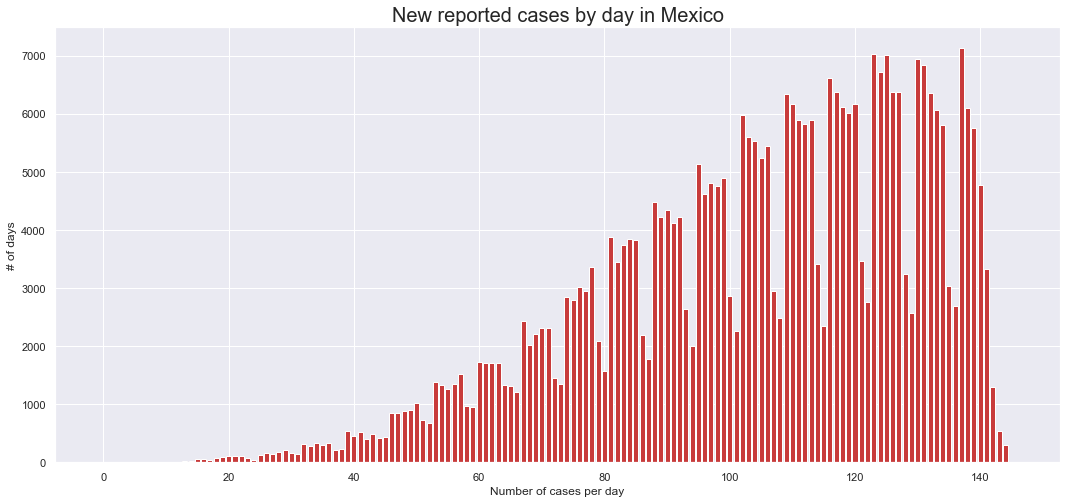

In [65]:
bar_char(df_positive_results.FECHA_INGRESO, 
         df_positive_results.POSITIVO,
         '#c83b3b', 
         'New reported cases by day in Mexico',
         '# of days',
         'Number of cases per day' )

In [66]:
bins = np.linspace(df_positive.FECHA_INGRESO_SEMANAL.min(), df_positive.FECHA_INGRESO_SEMANAL.max(), 10)
g = sns.FacetGrid(df_positive, col="SEXO", hue="DEF", palette="Set1", col_wrap=2)
g.map(plt.hist, 'FECHA_INGRESO_SEMANAL', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'FECHA_INGRESO_SEMANAL'

In [ ]:
pd.crosstab(df_positive['FECHA_INGRESO_SEMANAL'],df_positive.DEF).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_pout_bar')

The graph show a sharp decline every 6th and 7th day.

In [ ]:
correlation = df_general.corr()
plt.figure(figsize=(30, 10))
sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

## Hypothesize solution

### Which factor has the biggest impact on predicting death once infected with COVID-19?

In [ ]:
Logistic Regression
Decision Tree to predecit whether you die or live.



In [ ]:
Other questions to tackle are:
* Is there a correlation between cases and death with days of the week?
H0:

* Does the probability of death is increased by the number of days between first symptoms and hospitalization?
H0: 


---- 6 Hypothesize solution ----
The baseline model predicts the salary based on the data provided without fitting, feature generation or tunning.

Supervised Machine Learning algorithms will be used to improve the prediction results. Regression and Ensembles of Regression Algorithms suit our data and goal. 3 models that may improve results over the baseline model given the above EDA:

1.LinearRegression - Sometimes simple is best 2.RandomForestRegressor - Improved accuracy and control over-fittings 3.GradientBoostingRegressor - Can optimise on Least Squares regression.

Part 3 - DEVELOP
You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

Your metric will be MSE and your goal is:
<360 for entry-level data science roles
<320 for senior data science roles

## Develop